Time (GPU):  0.9478421211242676
Source Image:


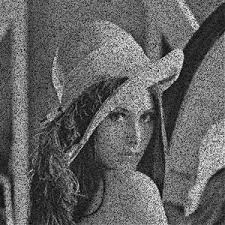

Median filtered Image GPU:


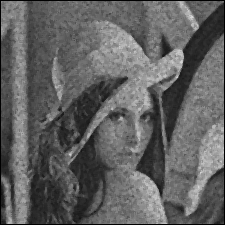

In [22]:
from numba import cuda
import numpy as np
from PIL import Image
import cv, cv2
import time
import math

@cuda.jit
def mf_kernel(input_image, output_image, width, height):
    """CUDA kernel for 9-point median filter."""
    # Define the position of the thread within the grid
    x, y = cuda.grid(2)

    if x < 1 or y < 1 or x >= width - 1 or y >= height - 1:
        # Skip the boundary pixels (cannot apply 3x3 filter)
        return

    # Create a list to hold the 9 pixels from the 3x3 region
    window = cuda.local.array(9, dtype=np.float32)

    idx = 0
    for j in range(-1, 2):
        for i in range(-1, 2):
            window[idx] = input_image[y + j, x + i]
            idx += 1

    # Bubble sort to find the median
    for i in range(9):
        for j in range(i + 1, 9):
            if window[i] > window[j]:
                temp = window[i]
                window[i] = window[j]
                window[j] = temp

    # Assign the median value to the output image
    output_image[y, x] = window[4]

def mf_gpu(input_image):
    """Applies a 9-point median filter using CUDA."""
    # Convert input image to float32 for compatibility
    input_image = input_image.astype(np.float32)

    # Get image dimensions
    height, width = input_image.shape

    # Allocate memory for the output image
    output_image = np.zeros((height, width))

    # Copy data to device
    cuda_input = cuda.to_device(input_image)
    cuda_output = cuda.to_device(output_image)

    # Define block and grid sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(width / threads_per_block[0])
    blocks_per_grid_y = math.ceil(height / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    mf_kernel[blocks_per_grid, threads_per_block](cuda_input, cuda_output, width, height)

    # Copy the result back to the host
    output_image = cuda_output.copy_to_host()

    return output_image

# Example source image (grayscale)
filename = 'sapimg.jpg'
src_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Perform median filter
start_gpu = time.time()
dst_image_gpu = mf_gpu(src_image)
time_gpu = time.time() - start_gpu

#Time
print("Time (GPU): ", time_gpu)

#images
print("Source Image:")
img = Image.fromarray(src_image)
display(img)

print("Median filtered Image GPU:")
dst_image_gpu= dst_image_gpu.astype(np.uint8)
img = Image.fromarray(dst_image_gpu)
display(img)